## Layer-wise Relevance Propogation

Based on the papers: <i>On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation</i> and <i>Layer-Wise Relevance Propagation for Deep Neural Network Architectures</i>.

Relevance score for node i in layer l:

$$ R_{\ell}^{i} = \bigg( \beta*\frac{z_{ij}^{+}}{z_{j}^{+}} + (1-\beta)*\frac{z_{ij}^{-}}{z_{j}^{-}} \bigg) R_{\ell+1}^{j} $$ 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Reshape,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train = np.expand_dims(x_train,axis=-1)
x_train,y_train = x_train[:24600],y_train[:24600]
x_train = np.reshape(x_train,(24600,-1))
x_train.shape,y_train.shape

((24600, 784), (24600,))

In [3]:
x_train = x_train/255 # scaling the images

In [4]:
def get_model():
    """ Simple feed-forward model
    """
    x = Input(shape=(784))
    h1 = Dense(100,activation='relu')(x)
    h2 = Dense(50,activation='relu')(h1)
    o = Dense(4,activation='softmax')(h2)
    
    model = Model(inputs=x,outputs=[h1,h2,o])
    return model

In [5]:
@tf.function
def train(model,optimizer,x_train_subset,y_train_subset):
    with tf.GradientTape() as tape:
        _,_,o = model(x_train_subset)
        loss = SparseCategoricalCrossentropy()(y_train_subset,o)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [6]:
model = get_model()

In [7]:
batch_size=50
epochs=5
optimizer = Adam(lr=0.01)

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
        
    print("Epoch {}: {}".format(epoch_i+1,round(sum(losses)/len(losses),6)))

Epoch 1: 0.102313
Epoch 2: 0.051911
Epoch 3: 0.037706
Epoch 4: 0.031262
Epoch 5: 0.032465


In [8]:
weights = {} # store all weights as numpy arrays
for i in range(0,len(model.trainable_variables)//2):
    weights["w"+str(i+1)] = model.trainable_variables[i*2].numpy()
    weights["b"+str(i+1)] = model.trainable_variables[i*2+1].numpy()

In [9]:
def generate_lrp_heatmap(example,weights,beta=0.5):
    """
    """
    example_to_print = example.reshape(28,28)
    example = np.expand_dims(example,axis=0)
    
    a1,a2,a3 = model(example)
    a1,a2,a3 = a1.numpy(),a2.numpy(),a3.numpy()
    inputs = {'a0':example,'a1':a1,'a2':a2}
    
    prev_r = [list(a3[0])] # the relevance of the previous layer

    for i in [3,2,1]:
        # getting relevance scores for all nodes in layer l, based on layer l+1:
        r_scores = [0 for _ in range(inputs['a'+str(i-1)].shape[-1])] # init scores for this layer
        prev_r_scores = prev_r[-1]

        for r_i in range(len(prev_r_scores)):

            z_i = np.squeeze((inputs['a'+str(i-1)]*weights['w'+str(i)][:,r_i]) + weights['b'+str(i)][r_i])
            z_plus = np.sum(z_i[z_i>=0])
            z_minus = np.sum(z_i[z_i<0])

            for j,z in enumerate(z_i):
                if z>=0:
                    z_score = beta*(z/z_plus)*prev_r_scores[r_i]
                else: # z<0
                    z_score = (1-beta)*(z/z_minus)*prev_r_scores[r_i]
                r_scores[j]+=z_score

        r_scores = r_scores/sum(r_scores)
        prev_r.append(r_scores)
        
    heatmap = np.reshape(np.array(r_scores),(28,28))
    return example_to_print,heatmap

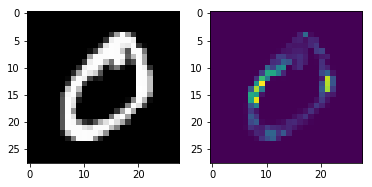

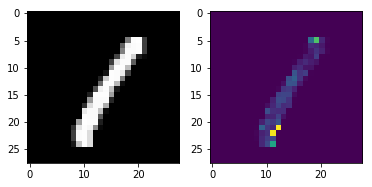

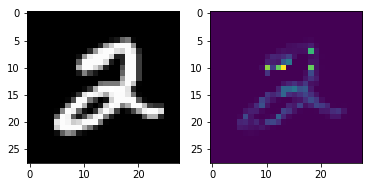

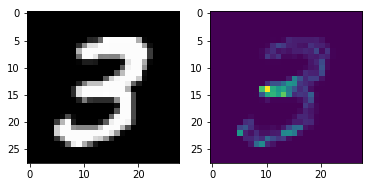

In [10]:
for i in [0,1,2,4]:
    example_to_print,heatmap = generate_lrp_heatmap(x_train[i],weights)
    plt.subplot(1,2,1)
    plt.imshow(example_to_print,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.show()